In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker

In [2]:
import tools

In [3]:
data = pd.read_json("data/flink/commits_20220602-16h05m47s_apache_flink_master_commits.txt", lines=True)
tools.initialize_datetime(data)
data = data.sort_values(by='authoredDate')
data['count'] = 1

## Commemorations

Would it be motivating, if contributors would receive commemorations for their work on Apache Flink?

In [4]:
contributor_total_contributions = data.groupby('authorName')['count'].count().reset_index()
contributor_total_contributions_dict = {k: v for k, v in contributor_total_contributions.values}

In [5]:
top_10_contributors = contributor_total_contributions.sort_values(by='count', ascending=False).set_index('authorName').head(10)['count']
tools.writefile(top_10_contributors, "top_10_contributors")
top_10_contributors

authorName
Till Rohrmann       2098
Chesnay Schepler    1976
Stephan Ewen        1761
Aljoscha Krettek    1091
Timo Walther         960
Fabian Hueske        795
Robert Metzger       739
Dawid Wysakowicz     693
Piotr Nowojski       593
Ufuk Celebi          435
Name: count, dtype: int64

The names of the biggest contributors seem to be the expected candidates. If there is a surprise here, then it is foremost the scale of the contributions by Till Rohrmann and Chesnay Schepler. Even though Stephan Ewen is close in contributions this would be expected from one of the founders and CTO of the project. 

In [6]:
contributor_list = data[['authorDatabaseId', 'authorLogin', 'authorName']].drop_duplicates().dropna().values
contributor_dict = {v[0]: (v[1], v[2]) for v in contributor_list}

In [9]:
contributions_over_time = data.loc[~data['authorName'].isna(), ['authoredDate', 'authorName', 'count']]
contributions_over_time['authoredDate'] = contributions_over_time['authoredDate'].dt.strftime('%Y-%m')
contributions_by_author_and_month = contributions_over_time\
    .groupby(['authoredDate', 'authorName'])['count']\
    .count()\
    .reset_index(1)
contributions_by_author_and_month = contributions_by_author_and_month.sort_values(by=['authoredDate', 'count'], ascending=False).set_index('authorName', append=True)

In [10]:
with pd.option_context("display.max_rows", 10000000):
    print(contributions_by_author_and_month.query("count > 5"))
    
tools.writefile(contributions_by_author_and_month.query("count > 5"), "monthly_top_performers")

                                       count
authoredDate authorName                     
2022-05      Sergey Nuyanzin              16
             Yun Gao                      16
             Ada Wang                     13
             Chesnay Schepler             13
             Alexander Preuß              11
             Zhu Zhu                       8
2022-04      Chesnay Schepler             79
             Dian Fu                      15
             Jing Ge                      15
             Timo Walther                  9
             Matthias Pohl                 7
             Francesco Guardiani           6
2022-03      Marios Trivyzas              34
             Chesnay Schepler             32
             Matthias Pohl                31
             Jing Ge                      16
             Francesco Guardiani          13
             Roman                        13
             Timo Walther                 10
             Gen Luo                       8
          

We can take a look at the contributors that added at least 5 commits in each month. What really strikes me as surprising is how contributors like Francesco Guardini suddenly appear on this list and remain a top scorer.

In [11]:
contributions_by_author = contributions_by_author_and_month.reset_index().set_index('authorName')

In [12]:
contributions_by_author.loc['Francesco Guardiani'].set_index('authoredDate').sort_index()

,count
authoredDate,
2021-09,18
2021-10,9
2021-11,33
2021-12,23
2022-01,35
2022-02,35
2022-03,13
2022-04,6


We can also look at the contributions of one individual per month. This could be used to determine awards. 

In [43]:
king_of_the_hill = contributions_by_author.groupby('authoredDate')['count'].idxmax().reset_index().values
king_of_the_hill_df = pd.DataFrame(king_of_the_hill, columns=['month', 'author'])
tools.writefile(king_of_the_hill_df.set_index('month'), "king_of_the_hill")
king_of_the_hill = {k: v for k,v in king_of_the_hill}

We may as well ask for the most important contributor for any given month. I choose to refer to them as "King of the Hill". This could be one of the rewards. Although, people that are already heavily contributing probably don't need further motivation.

In [17]:
from matplotlib.patches import Rectangle

In [18]:
from enum import Enum

class MonthlyAwardsLevel:
    BRONZE = 2
    SILVER = 8
    GOLD = 20
    
class MonthlyAwards(Enum):
    BRONZE = 2
    SILVER = 3
    GOLD = 4
    KING_OF_THE_HILL = 5
    NOTHING = 6

In total, we could have five awards. King-of-the-hill awards for the most prominent contributor of the month (or year), bronze, silver, and gold awards for frequent contributors and first-time awards for contibutors doing their very first contribution. (We haven't implemented the last one)

In [13]:
contributions_by_month = contributions_by_author_and_month.reset_index().set_index('authoredDate')

In [14]:
contributions_by_month.loc['2022-03']

,authorName,count
authoredDate,,
2022-03,Marios Trivyzas,34
2022-03,Chesnay Schepler,32
2022-03,Matthias Pohl,31
2022-03,Jing Ge,16
2022-03,Francesco Guardiani,13
...,...,...
2022-03,huweihua,1
2022-03,longwang,1
2022-03,ruanshubin,1


[Text(0.5, 0, 'number of commits'),
 Text(0, 0.5, 'percentage'),
 Text(0.5, 1.0, 'Award levels')]

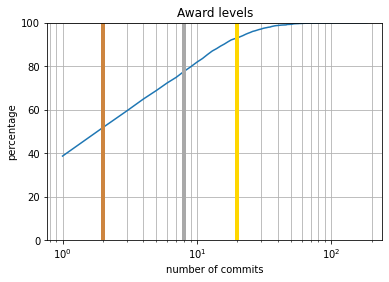

In [44]:
counts = contributions_by_month['count'].value_counts().sort_index()
f, ax = plt.subplots()
(counts.cumsum() / counts.sum() * 100).plot(ax=ax)
ax.grid(which='both')
ax.set(xscale='log', ylim=(0, 100))
ax.axvline(MonthlyAwardsLevel.BRONZE, color='peru', lw=4)
ax.axvline(MonthlyAwardsLevel.SILVER, color='darkgray', lw=4)
ax.axvline(MonthlyAwardsLevel.GOLD, color='gold', lw=4)
ax.set(xlabel='number of commits', ylabel='percentage', title='Award levels')

We can make the awards attractive by making them increasingly difficult to reach.

In [24]:
first_time = contributions_over_time[['authoredDate', 'authorName']].groupby('authorName').min().reset_index().values
first_time = {k: v for k, v in first_time}

In [25]:
def assign_award(name: str, month: str):
    if name == king_of_the_hill[month]:
        return MonthlyAwards.KING_OF_THE_HILL
    try:
        count = contributions_by_author_and_month.loc[month, name].values[0]
    except KeyError:
        return MonthlyAwards.NOTHING
    if count >= MonthlyAwardsLevel.GOLD:
        return MonthlyAwards.GOLD
    if count >= MonthlyAwardsLevel.SILVER:
        return MonthlyAwards.SILVER
    if count >= MonthlyAwardsLevel.BRONZE:
        return MonthlyAwards.BRONZE
    return MonthlyAwards.NOTHING

In [26]:
def get_all_awards(name: str):
    bronze, silver, gold, king = 0, 0, 0, 0
    for month in sorted(contributions_by_author_and_month.reset_index()['authoredDate'].unique()):
        award = assign_award(name, month)
        if award == MonthlyAwards.NOTHING:
            continue
        if award == MonthlyAwards.BRONZE:
            bronze += 1
        if award == MonthlyAwards.SILVER:
            silver += 1
        if award == MonthlyAwards.GOLD:
            gold += 1
        if award == MonthlyAwards.KING_OF_THE_HILL:
            king += 1
        print(month, award.name.replace('_', ' '))
    first = first_time[name]
    print(f"First time at {first}")
    print(f'Bronze {bronze}, Silver {silver}, Gold {gold}, King-of-the-hill {king}')

In [27]:
get_all_awards("Stephan Ewen")

2013-08 KING OF THE HILL
2014-06 KING OF THE HILL
2014-07 GOLD
2014-08 SILVER
2014-09 KING OF THE HILL
2014-10 KING OF THE HILL
2014-11 KING OF THE HILL
2014-12 GOLD
2015-01 KING OF THE HILL
2015-02 KING OF THE HILL
2015-03 KING OF THE HILL
2015-04 KING OF THE HILL
2015-05 KING OF THE HILL
2015-06 SILVER
2015-07 KING OF THE HILL
2015-08 KING OF THE HILL
2015-09 KING OF THE HILL
2015-10 GOLD
2015-11 GOLD
2015-12 SILVER
2016-01 KING OF THE HILL
2016-02 KING OF THE HILL
2016-03 SILVER
2016-04 SILVER
2016-05 SILVER
2016-06 BRONZE
2016-07 BRONZE
2016-08 KING OF THE HILL
2016-09 KING OF THE HILL
2016-10 KING OF THE HILL
2016-11 KING OF THE HILL
2016-12 KING OF THE HILL
2017-01 KING OF THE HILL
2017-02 KING OF THE HILL
2017-03 GOLD
2017-04 SILVER
2017-05 GOLD
2017-07 SILVER
2017-10 GOLD
2017-11 GOLD
2017-12 SILVER
2018-01 GOLD
2018-02 GOLD
2018-03 SILVER
2018-04 SILVER
2018-05 GOLD
2018-07 SILVER
2018-08 BRONZE
2018-09 SILVER
2018-10 SILVER
2018-11 SILVER
2019-04 BRONZE
2019-05 BRONZE
2019-06

This is an example for Stephan Ewen.